# Pedestrian Counting Tool

In [1]:
# allow reloading functions from imports without clearing kernel
%load_ext autoreload
%autoreload 2

In [2]:
# image/video processing
import cv2 
import cvlib as cv
from cvlib.object_detection import draw_bbox

# plot
import matplotlib.pyplot as plt
%matplotlib inline

# utilities
from tqdm.notebook import trange, tqdm  # progress bar
import utils
import numpy as np
import csv
import os
import math

## Project Setup

### $\Rightarrow$ file/folder settings

In [3]:
input_video = 'input/video1.mp4'

output_folder = 'output'

frame_folder = f'{output_folder}/1_frames'
detection_folder = f'{output_folder}/2_detections'
tracking_folder = f'{output_folder}/3_trackings'
counting_folder = f'{output_folder}/4_counting'

detection_file = 'detections.txt'
tracking_file = 'trackings.txt'
counting_file = 'counts.txt'

In [4]:
# check if output folders exist, if not create them
utils.create_folders([frame_folder, 
                      detection_folder, 
                      tracking_folder, 
                      counting_folder])

### $\Rightarrow$ get frames from input video

In [ ]:
# convert video to a sequence of images
frame_count = utils.get_frames(input_video, frame_folder, first_N=None, resize=1.0)

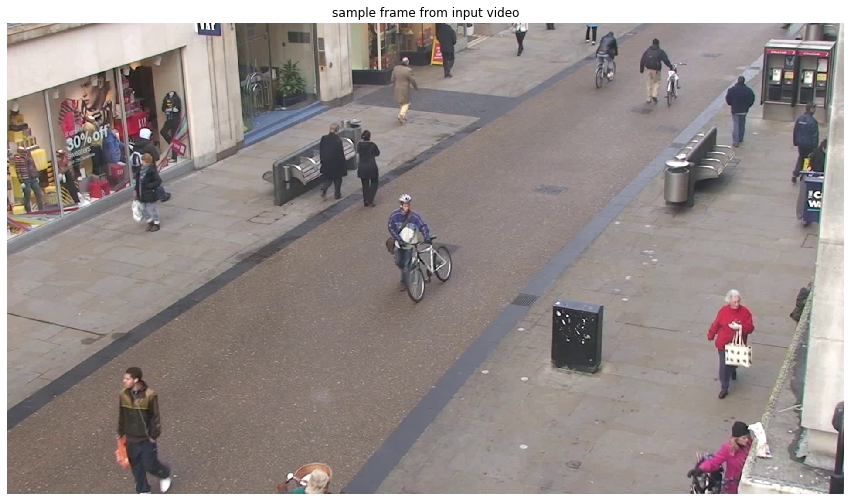

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

sample_frame = cv2.imread(f'{frame_folder}/f000001.jpg')
fig, ax = plt.subplots(1, 1, figsize=(15,10))
ax.imshow(cv2.cvtColor(sample_frame, cv2.COLOR_BGR2RGB))
ax.set_title('sample frame from input video'), ax.axis('off')
plt.show()

## Step 1. Detect Objects In Each Frame

*cvlib* library was used for detecting objects in each frame. I used the <code>cv.detect_common_objects()</code> function to detect common objects and filter for 'person' class. These 'person' detections are stored in a text file.

* cvlib - high level Computer Vision library for Python, Arun Ponnusamy, 2018

[https://github.com/arunponnusamy/cvlib](https://github.com/arunponnusamy/cvlib)


In [ ]:
detections = []

for i in tqdm(range(1, frame_count+1)):
    
    # read frame
    im = cv2.imread(f'{frame_folder}/f{i:06d}.jpg')
    
    # detect common objects and add persons to detections
    bbox, label, conf = cv.detect_common_objects(im)
    for j in range(len(label)):
        if label[j] == 'person':
            bb_left = bbox[j][0]
            bb_top = bbox[j][1]
            bb_right = bbox[j][2]
            bb_bottom = bbox[j][3]
            detections.append([i, -1, bb_left, bb_top, bb_right, bb_bottom, conf[j]])
    
    # label detections and save frames
    detobj_im = draw_bbox(im, bbox, label, conf)
    cv2.imwrite(f'{detection_folder}/f{i:06d}.jpg', detobj_im)

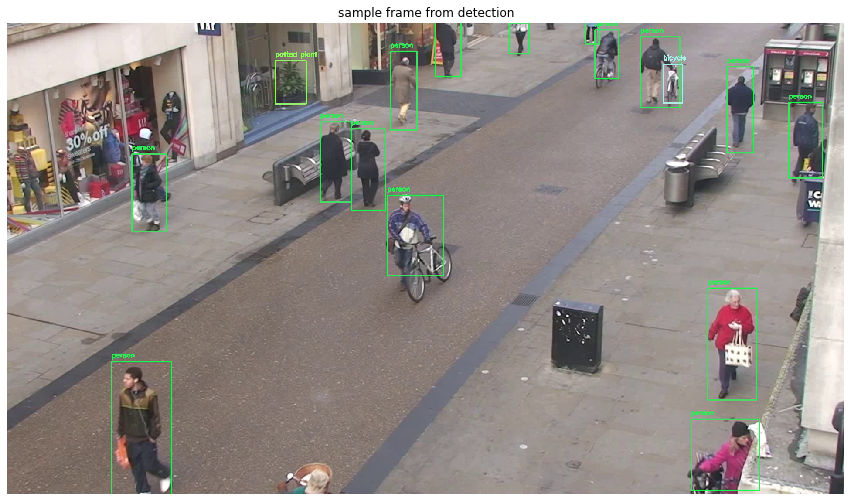

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

sample_frame = cv2.imread(f'{detection_folder}/f000001.jpg')
fig, ax = plt.subplots(1, 1, figsize=(15,10))
ax.imshow(cv2.cvtColor(sample_frame, cv2.COLOR_BGR2RGB))
ax.set_title('sample frame from detection'), ax.axis('off')
plt.show()

### $\Rightarrow$ store detections in a file

In [ ]:
with open(f'{detection_folder}/{detection_file}',"w", newline='') as f:
    wr = csv.writer(f)
    wr.writerows(detections)

## Step 2. Track Objects In Each Frame

*SORT* was used for object tracking between frames. Note that the tracker cell needs to be run only ONCE. Otherwise, tracker will start assigning *id* values starting from the last largest assignment. Please reset the kernel and clear the output before attempting another run.
  
* Simple online and realtime tracking, Bewley, Alex and Ge, Zongyuan and Ott, Lionel and Ramos, Fabio and Upcroft, Ben, 2016 IEEE International Conference on Image Processing (ICIP), 2016, pages 3464-3468, doi={10.1109/ICIP.2016.7533003

[https://github.com/abewley/sort](https://github.com/abewley/sort)

In [ ]:
from sort import *

# create instance of SORT
mot_tracker = Sort(max_age=10) 

# get stored detections
detections = np.loadtxt(f'{detection_folder}/{detection_file}', delimiter=',')

# track objects    
with open(f'{tracking_folder}/{tracking_file}','w') as trf:
    
    for i in tqdm(range(1, frame_count+1)):
        dets = detections[detections[:, 0]==i, 2:7]

        current_frame = f'{frame_folder}/f{i:06d}.jpg'
        im = cv2.imread(current_frame)
        
        # receive trackings for the current frame
        trackers = mot_tracker.update(dets).astype(np.int32)
        
        for d in trackers:
            print(f'{i:d},{d[4]:d},{d[0]:d},{d[1]:d},{d[2]:d},{d[3]:d},{0:d},{0:d},{0:d}', 
                  file=trf)
        
        # add labels to tracked objects
        tracked_im = utils.annotate_image(im, 
                                          trackers[:,:4], 
                                          ['person'] * trackers.shape[0],
                                          trackers[:,4])
        
        # save frames with annotations
        cv2.imwrite(f'{tracking_folder}/f{i:06d}.jpg', tracked_im)

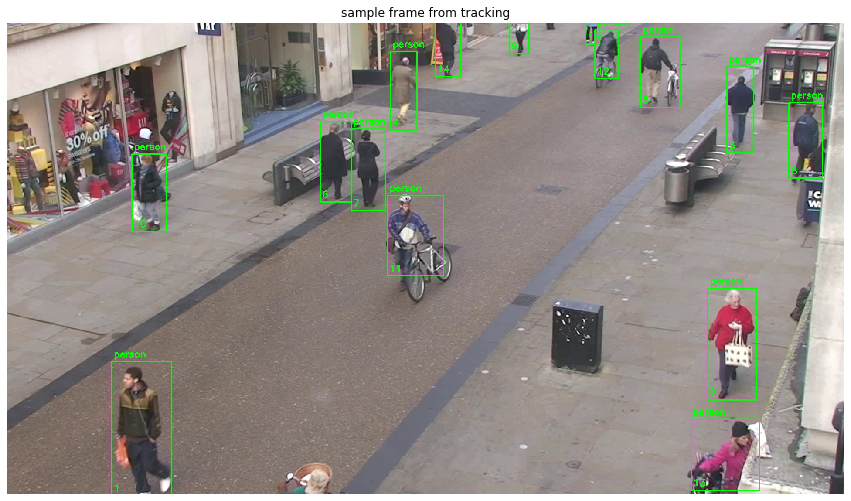

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

sample_frame = cv2.imread(f'{tracking_folder}/f000001.jpg')
fig, ax = plt.subplots(1, 1, figsize=(15,10))
ax.imshow(cv2.cvtColor(sample_frame, cv2.COLOR_BGR2RGB))
ax.set_title('sample frame from tracking'), ax.axis('off')
plt.show()

### $\Rightarrow$ animate tracking process

In [ ]:
utils.animate_frames(tracking_folder, save_dir=f'{output_folder}/tracking_video.avi', fps=25)

## Step 3. Count Objects

### $\Rightarrow$ set counter line

If it doesn't get you to the drawing mode, then rerun this function again.


<IPython.core.display.Javascript object>


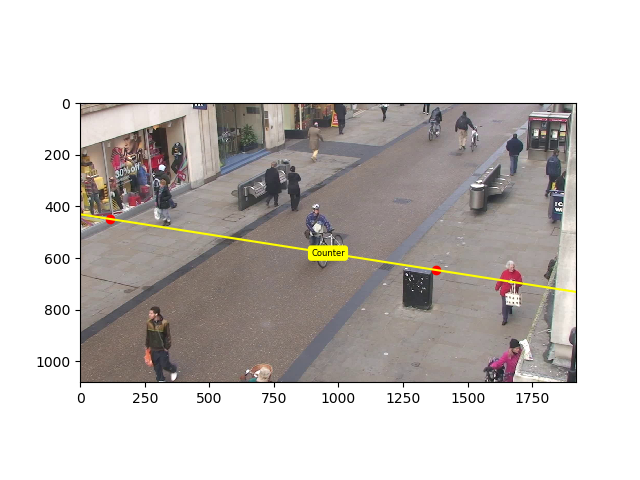

In [4]:
import matplotlib.pyplot as plt
%matplotlib notebook

im = cv2.imread(f'{frame_folder}/f000001.jpg')
line_coords, line_coefs = utils.set_counter_line(im)

### $\Rightarrow$ count tracked objects

In [ ]:
# get stored tracked_objects
trackings = np.loadtxt(f'{tracking_folder}/{tracking_file}', delimiter=',').astype(np.int32)

# counters
n_regA = 0
n_regB = 0

# object's last known region
regions= {}

# count objects that pass the counter line on both sides
with open(f'{counting_folder}/{counting_file}','w') as trf:

    for i in tqdm(range(1, frame_count+1)):
        
        # get current frame trackings
        objs = trackings[trackings[:, 0]==i, :]
            
        # count objects
        for j, obj in enumerate(objs):
            
            oid = obj[1]
            objs[j][6] = utils.find_region(obj[2:], line_coords)
            
            # check if object changed region between frames
            if i > 1:
                if oid in regions:
                    if (objs[j][6] != regions[oid]):
                        if (regions[oid] == 1):
                            n_regB += 1
                        else:
                            n_regA += 1

            objs[j][7] = n_regA
            objs[j][8] = n_regB
            print(f'{objs[j][0]:d},{objs[j][1]:d},{objs[j][6]:d},{objs[j][7]:d},{objs[j][8]:d}', 
                  file=trf)
        
            regions[oid] = objs[j][6]
        
        current_frame = f'{frame_folder}/f{i:06d}.jpg'
        im = cv2.imread(current_frame)
        
        counted_im = utils.annotate_counting(im, objs, line_coords, line_coefs)
        cv2.imwrite(f'{counting_folder}/f{i:06d}.jpg', counted_im)

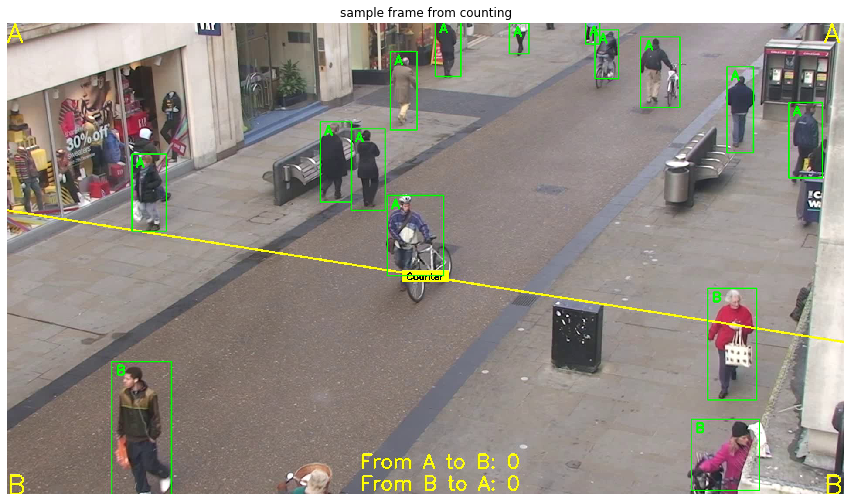

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

sample_frame = cv2.imread(f'{counting_folder}/f000001.jpg')
fig, ax = plt.subplots(1, 1, figsize=(15,10))
ax.imshow(cv2.cvtColor(sample_frame, cv2.COLOR_BGR2RGB))
ax.set_title('sample frame from counting'), ax.axis('off')
plt.show()

### $\Rightarrow$ animate counting process

In [ ]:
utils.animate_frames(counting_folder, save_dir=f'{output_folder}/counting_video.avi', fps=25)